In [147]:
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

import json
from glob import glob
import os

from importlib import reload

import utils

import tifffile as tf
from KDEpy import FFTKDE
from scipy import ndimage,stats
from sklearn import preprocessing, tree, metrics, linear_model

In [2]:
nuclei_mask_cutoff = 1
seed = 42
ndims = 3
fs = 12
PP = 6
dpi = 96
minlife = 0.0
rng = np.random.default_rng(seed)
permmethod = stats.PermutationMethod(n_resamples=999, random_state=rng)

Cmap='plasma'
pxs = 75
pxbar = np.s_[-25:-5, 5:5 + pxs]
s = 50
alphaNmin = 0.1
alphaNmax = 10

wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'RdPu_r', 'Greens_r', 'BuPu_r', 'Oranges_r', 'Wistia', 'YlOrBr_r', 'gray', 'gist_gray']
box_params = {'widths':0.75, 'patch_artist':True, 'medianprops':{'lw':3, 'color':'red'} }
#figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
sample = 'D2'

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/' + sample + os.sep
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep + sample + os.sep
geosrc =  '..' + os.sep + 'geometry' + os.sep + sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col='ndimage_cellID')
metaecc = pd.read_csv(ksrc + sample + '_nodule_root_eccentricity.csv', index_col='ndimage_cellID')
metaecc['eccentricity'] = metaecc['eccentricity'].max() - metaecc['eccentricity'].values

metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv').set_index('gene')
cell_nuc = pd.read_csv(ksrc + sample + '_nuclei_limits.csv')
cell_nuc.loc[cell_nuc['n_bot'] == 1, 'n_bot'] = 0
cell_nuc.loc[cell_nuc['n_top'] == 61, 'n_top'] = 65

transcriptomes = np.asarray(list(metatrans['gene']))
metatrans = metatrans.set_index('gene')

Cells = utils.get_range_cell_values(isrc + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)

Genes = utils.get_range_gene_values(isrc + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
Cs = dict(zip(Genes, ['#56b4e9','#cc79a7']))
Ms = dict(zip(Genes, ['D','s']))
Ps = dict(zip(Genes, ['Blues_r','PuRd_r']))
invGenes = dict(zip(Genes, range(len(Genes))))
invCells = dict(zip(Cells, range(len(Cells))))
transfocus = transcell.loc[transcriptomes[Genes], Cells.astype(str)]

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
print('Detected',cellnum,'cells')

lnuc, nnuc = ndimage.label(tf.imread(nsrc + sample + '_EDT.tif') < nuclei_mask_cutoff, ndimage.generate_binary_structure(2,1))
print('Detected',nnuc,'nuclei')
wcoords = np.asarray(np.nonzero(~wall))
foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = mpl.colors.ListedColormap(foo)

wc = wcoords[:, ~np.all(wcoords%100, axis=0)]

translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
    translocs[i]['cidx'] = label[ translocs[i]['Y'], translocs[i]['X'] ]
    translocs[i]['nidx'] =  lnuc[ translocs[i]['Y'], translocs[i]['X'] ]

tlocs = pd.concat(translocs)

Detected 2937 cells
Detected 1365 nuclei


# Bring in persistence images to the party

In [5]:
level = 'sub'
normtype = 'both'
stepsize = 3
bw = 25
SCALE = 32

zmax = np.max(tlocs['Z']+stepsize)
zbins = np.arange(0, zmax+stepsize, stepsize)

dsrc = isrc + 'G{}_{}level_{}_step{}_bw{}'.format(len(Genes), level, normtype, stepsize, bw) + os.sep
ratios = utils.normalize_counts(transfocus, normtype)

jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]
gsrc = '../{}level/'.format(level) + sample + os.sep
for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

orig_diags = [ utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True) for i in range(len(jsonfiles))]
orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)

kde_max = np.zeros(ratios.size)
for i in range(len(orig_diags)):
    for j in range(len(orig_diags[i])):
        if len(orig_diags[i][j][focus_dim]) > 0:
            kde_max[i*len(orig_diags[i]) + j] = np.max(orig_diags[i][j][focus_dim])

kmax = np.sort(kde_max)[-20]

Initial number of life-birth pairs	: 64671

No. of diagrams s.t. H_k had the most persistent component
H_0:	26 [ 1.4% ]
H_1:	142 [ 7.7% ]
H_2:	1668 [ 90.8% ]

Will focus just on dimension k = 2



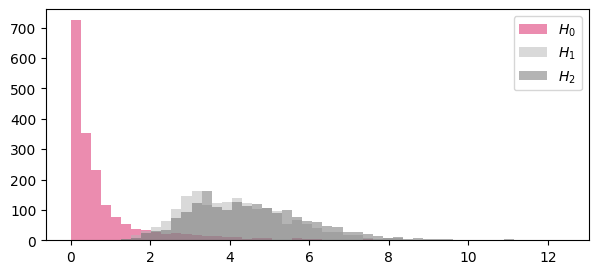

In [8]:
maxl = np.vstack(maxlife)
bins = np.linspace(0, maxl.max(), 50)

fig, ax = plt.subplots(1,1, figsize=(7,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0
for i in range(maxl.shape[1]):
    ax[j].hist(maxl[:,i], bins=bins, color=wong[i], alpha=0.5, label='$H_{{{}}}$'.format(i))
ax[j].legend();

In [414]:
KBINS_NO = 27
foo = [pd.DataFrame(np.zeros((len(Genes), KBINS_NO-1)), index=Genes, columns=range(1,KBINS_NO)) for _ in range(len(Cells))]
peripherality = dict(zip( Cells, foo ))
for cidx in Cells:
    foo = pd.read_csv(geosrc + 'peripherality_c{:06d}.csv'.format(cidx))
    for gidx in Genes:
        ys = ratios[invGenes[gidx] , invCells[cidx]] * foo['mean_{}_-_{}'.format(bw, transcriptomes[gidx])].values / kmax
        peripherality[cidx].loc[gidx, :] = ys

pss=np.s_[4:-3]
kbins = np.linspace(0, 1, KBINS_NO)
Xs = np.linspace(0,1, peripherality[Cells[0]].shape[1])
xs = Xs[pss]

# Loadings

In [431]:
cidx = 1494
cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, pxbar=True, PP=6)
s_ = (np.s_[cextent[2]:cextent[3]], np.s_[cextent[0]:cextent[1]])
edt = ndimage.distance_transform_edt(label[s_] == cidx)
edt = edt/edt.max()
axes, grid, kdegmask, cgrid, outside_walls = utils.cell_grid_preparation(cidx, cell, label[s_], cextent, zmax, stepsize, cell_nuc)
alpha = min([1.5*int(4e6/cell.size)/100, 0.8])

cellhist = np.digitize(edt, kbins, right=True)
hsummary = [None for _ in range(len(Genes))]
hhist = [cellhist.copy() for _ in range(len(Genes))]

for i in range(len(Genes)):
    hsummary[i] = peripherality[cidx].loc[Genes[i]].values
    temp = (1e6*np.hstack(([0], hsummary[i]))).astype(int)
    with np.nditer(hhist[i], flags=['external_loop'], op_flags=['readwrite']) as it:
        for x in it:
            x[...] = temp[x]

    hsummary[i] = hsummary[i][pss]
#loc_smax = 1e6*max([ max(map(np.max, hsummary[i])) for i in range(len(hsummary)) ])

In [432]:
hcoords, hkde = [ [] for _ in range(2) ]

for gidx in Genes:

    coords = translocs[gidx].loc[ translocs[gidx]['cidx'] == cidx , ['X', 'Y', 'Z'] ].values.T
    
    kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(coords.T).evaluate(grid)
    kde = kde[kdegmask]/(np.sum(kde[kdegmask])*(stepsize**len(coords)))
    kde[outside_walls] = 0
    
    kde = kde/(np.sum(kde)*(stepsize**len(coords)))
    kde = kde.reshape( list(map(len, axes))[::-1], order='F')
       
    hkde.append( kde.copy() * ratios[invGenes[gidx]][invCells[cidx]] )
    hcoords.append(coords)

loc_kmax = max(map(np.max, hkde))
loc_smax = 1e6*loc_kmax/kmax

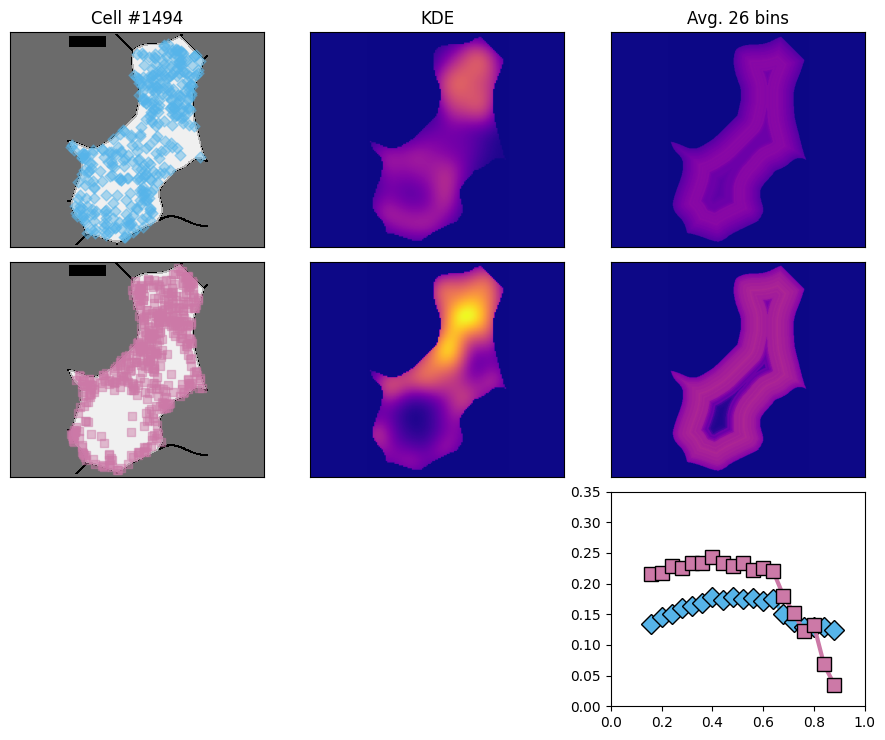

In [433]:
fig, ax = plt.subplots(3, 2+1, figsize=(6+3*1, 7.5), sharex=False, sharey=False)

for i in range(len(Genes)):
    j = 0
    ax[i,j].imshow(cell+1, cmap=cellular_cmap, origin='lower', extent=cextent, vmin=0, vmax=nnuc+2);
    ax[i,j].scatter(*(hcoords[i][:2]), color=Cs[Genes[i]], marker=Ms[Genes[i]], alpha=alpha, s=int(4e6/cell.size))
    ax[i,j].set_facecolor(wong[2])

    j += 1
    ax[i,j].imshow(np.max(hkde[i], axis=0), origin='lower', cmap=Cmap, vmin=0, vmax=loc_kmax, zorder=1)
    ax[i,j].set_facecolor( mpl.colormaps[ Cmap ](0) )

    j += 1
    ax[i, j].imshow(hhist[i], origin='lower', cmap=Cmap, vmin=0, vmax=loc_smax)
    ax[i, j].set_facecolor( mpl.colormaps[ Cmap ](0) )

ax[0,0].set_title('Cell #{}'.format(cidx), fontsize=fs)
ax[0,1].set_title('KDE', fontsize=fs)

i = 0
ax[0,2+i].set_title('Avg. {} bins'.format(KBINS_NO-1), fontsize=fs)
for j in range(len(Genes)):
    ax[2,2].plot(Xs[pss], hsummary[j], color=Cs[Genes[j]], lw=3, marker=Ms[Genes[j]], ms=10, mec='k', mew=1)
    ax[2,2].set_ylim(0, max([peripherality[cidx].max(axis=None), 0.3])+0.05);
    ax[2,2].set_xlim(0,1)

for ix in [(2,0), (2,1)]:
    fig.delaxes(ax[ix])
    

for a in ax.ravel()[:(4 + 2*1)]:
    a.set_aspect('equal','datalim')
    a.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.tight_layout()
#plt.savefig('cell{}_periphery_analyses.png'.format(cidx), dpi=dpi, bbox_inches='tight', format='png')

#print(hsummary[0][0], '--', hsummary[1][0], sep='\n')

In [427]:
pss = np.s_[4:-3]

GLYMA_17G195900_-_	0.007555195860951908
--
 [ 8.50e-04  1.86e-03  5.60e-04  1.64e-03  5.00e-04  1.00e-03  1.69e-03
 -8.20e-04  7.00e-04 -4.80e-04  3.90e-04 -1.02e-03  7.40e-04 -3.84e-03
 -1.79e-03 -9.10e-04 -8.00e-05 -6.00e-05 -5.70e-04] 

GLYMA_05G092200_-_	0.02680903293289232
--
 [ 0.00209  0.00031  0.00253 -0.00066  0.00207 -0.00027  0.00239 -0.00222
 -0.00096  0.00087 -0.00225  0.0007  -0.00136 -0.00717 -0.00423 -0.00363
  0.00123 -0.00435 -0.00116] 



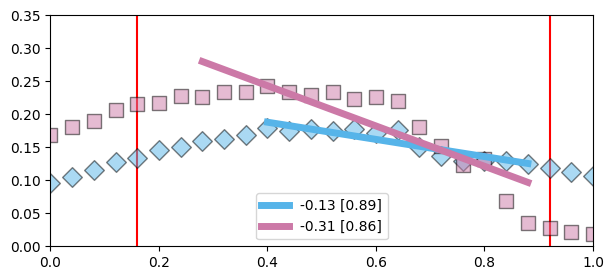

In [430]:
tol = 5e-4

cidx = 1494

fig, ax = plt.subplots(1,1, figsize=(7,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].axvline(Xs[pss.start], c='r', zorder=1)
ax[j].axvline(Xs[pss.stop], c='r', zorder=1)
#ax[j].axhline(tol, c='b', zorder=1, ls='--')
for gidx in Genes:
#for gidx in [85]:
    
    t = transcriptomes[gidx] + '_-_'
    Ys = peripherality[cidx].loc[gidx].values
    tol_msk = np.abs(Ys[pss] * np.ediff1d(Ys)[pss.start-1:pss.stop]) > tol
    tol_msk |= Ys[pss] > 0.15
    
    while (np.sum(tol_msk) < 7) & (tol > 1e-5):
        print('while')
        tol /= 2
        tol_msk |= np.abs(Ys[pss] * np.ediff1d(Ys)[pss.start-1:pss.stop]) > tol
    
    dys = np.gradient(Ys, Xs, edge_order=1)[pss][tol_msk]
    uq, cts = np.unique(np.sign(dys), return_counts=True)
    sgn_msk = np.sign(dys + uq[np.argmax(cts)]*0.1) == uq[np.argmax(cts)]
    
    ys = Ys[pss][tol_msk][sgn_msk]
    xs = Xs[pss][tol_msk][sgn_msk]

    linregress = stats.linregress(xs, ys)
    m,b,r = linregress.slope, linregress.intercept, np.abs(linregress.rvalue)
    print(t, metrics.mean_absolute_error(ys, m*xs + b), sep='\t')

    ax[j].scatter(Xs, Ys, color=Cs[gidx], marker=Ms[gidx], edgecolor='k', s=100, zorder=2, alpha=0.5)
    ax[j].plot( [ xs[0], xs[-1] ], [m*xs[0] + b, m*xs[-1]+b], c=Cs[gidx] , zorder=3, lw=5, label='{:.2f} [{:.2f}]'.format(m,r))

    print('--\n', np.round(Ys[pss] * np.ediff1d(Ys)[pss.start-1:pss.stop], 5),'\n')
ax[j].legend()
ax[j].set_xlim(0,1)
ax[j].set_ylim(0, max([peripherality[cidx].max(axis=None), 0.3])+0.05);

In [404]:
np.abs(Ys[pss] * np.ediff1d(Ys)[pss.start-1:pss.stop]) > tol

array([ True,  True,  True, False, False, False,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
       False])

In [398]:
xs

array([0.28, 0.32, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72,
       0.76, 0.8 , 0.84, 0.88])

In [300]:
Ys[pss][1:]*np.ediff1d(Ys[pss])

array([ 1.86590649e-03,  9.96723152e-04,  1.15987280e-03,  9.62097186e-04,
        4.24130864e-05,  4.06215324e-04,  4.48984450e-04, -5.93807326e-04,
        2.18174843e-04,  5.60921312e-05, -4.23891570e-04,  6.40778537e-05,
       -4.33992215e-05,  2.09839704e-04,  7.14500659e-04, -1.08630961e-04,
        1.29990350e-03,  1.55763414e-03])

In [241]:
cc = ['m', 'b', 'r', 'mae', 'start', 'stop']
colnames = []
for gidx in Genes:
    colnames += [ '{}_-_{}'.format(transcriptomes[gidx], c) for c in cc ]
    
colnames = np.asarray(colnames)

In [360]:
cidx

820

In [388]:
df = pd.DataFrame(np.zeros( (len(Cells), len(colnames)) ) , index=Cells, columns=colnames)
for cidx in Cells:
    for gidx in Genes:
        tol = 5e-4
        t = transcriptomes[gidx] + '_-_'
        Ys = peripherality[cidx].loc[gidx].values
        
        tol_msk = Ys[pss] > 0.15
        tol_msk |= np.abs(Ys[pss] * np.ediff1d(Ys)[pss.start-1:pss.stop]) > tol
        while (np.sum(tol_msk) < 7) & (tol > 1e-5):
            tol /= 2
            tol_msk |= np.abs(Ys[pss] * np.ediff1d(Ys)[pss.start-1:pss.stop]) > tol
        dys = np.gradient(Ys, Xs, edge_order=1)[pss][tol_msk]
        uq, cts = np.unique(np.sign(dys), return_counts=True)
        sgn_msk = np.sign(dys + uq[np.argmax(cts)]*0.1) == uq[np.argmax(cts)]
        
        ys = Ys[pss][tol_msk][sgn_msk]
        xs = Xs[pss][tol_msk][sgn_msk]
    
        linregress = stats.linregress(xs, ys)
        m,b,r = linregress.slope, linregress.intercept, np.abs(linregress.rvalue)
        mae = metrics.mean_absolute_error(ys, m*xs + b)
        
        df.loc[cidx, t + 'm'] = m
        df.loc[cidx, t + 'b'] = b
        df.loc[cidx, t + 'r'] = r
        df.loc[cidx, t + 'mae'] = mae
        df.loc[cidx, t + 'start'] = xs[0]
        df.loc[cidx, t + 'stop'] = xs[-1]
print(df.shape)

(918, 12)


In [406]:
df.sort_values(by='GLYMA_05G092200_-_mae', ascending=False).head(10)

,GLYMA_17G195900_-_m,GLYMA_17G195900_-_b,GLYMA_17G195900_-_r,GLYMA_17G195900_-_mae,GLYMA_17G195900_-_start,GLYMA_17G195900_-_stop,GLYMA_05G092200_-_m,GLYMA_05G092200_-_b,GLYMA_05G092200_-_r,GLYMA_05G092200_-_mae,GLYMA_05G092200_-_start,GLYMA_05G092200_-_stop
1640,0.128225,0.102631,0.993976,0.002557,0.16,0.88,0.031636,0.319090,0.176519,0.036034,0.16,0.88
744,0.308293,0.288745,0.968047,0.014909,0.16,0.88,-0.436857,0.487366,0.931330,0.028581,0.24,0.88
1494,-0.130223,0.240083,0.891216,0.007555,0.40,0.88,-0.305163,0.365370,0.858796,0.026809,0.28,0.88
1417,0.065660,0.198842,0.661298,0.013514,0.16,0.88,-0.238636,0.287968,0.847754,0.022257,0.24,0.84
2077,0.132564,0.209066,0.887282,0.013985,0.16,0.88,-0.395739,0.506543,0.955376,0.021688,0.20,0.88
1873,0.172607,0.178482,0.972740,0.007814,0.16,0.88,0.103534,0.470204,0.679018,0.021489,0.16,0.88
2282,0.078540,0.163028,0.849053,0.009337,0.16,0.88,-0.414212,0.458511,0.955106,0.021287,0.20,0.88
1966,0.134854,0.130084,0.944047,0.008789,0.16,0.88,-0.168271,0.315504,0.774484,0.021137,0.16,0.84
818,0.058290,0.272508,0.869061,0.004396,0.16,0.80,-0.283977,0.251902,0.919996,0.019925,0.16,0.84
1572,0.187542,0.161678,0.986476,0.005794,0.16,0.88,-0.507256,0.519160,0.969951,0.019915,0.24,0.88


In [86]:
cts

array([20,  1,  2])

In [84]:
y_pred

array([0.24690292, 0.26603881,        nan, 0.2814246 , 0.28368462,
       0.28594464, 0.28820467, 0.29046469, 0.29272471, 0.29498473,
       0.29724475, 0.29950477, 0.30176479, 0.30402482, 0.30628484,
       0.30854486, 0.31080488, 0.3130649 , 0.31532492, 0.31758494,
       0.31984497, 0.32210499, 0.32436501])

# Piecewise linear approximation

In [9]:
cc = ['m', 'b', 'len', 'start', 'stop', 'contig']
ce = ['MAPE', 'MAE', 'MSE']

colnames = []
dtypes = {}

for gidx in Genes:
    for n_seg in [2,3]:
        for j in range(n_seg):
            colnames += [ '{}-L{}{}-{}'.format(transcriptomes[gidx], n_seg, j, c) for c in cc ]
            for c in ['len', 'start', 'stop']:
                dtypes['{}-L{}{}-{}'.format(transcriptomes[gidx], n_seg, j, c)] = int
            dtypes['{}-L{}{}-{}'.format(transcriptomes[gidx], n_seg, j, 'contig')] = bool
        colnames += [ '{}-L{}-{}'.format(transcriptomes[gidx], n_seg, c) for c in ce ]

colnames = np.asarray(colnames)

In [17]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
data = np.zeros( (len(Cells), len(colnames)) )

for i in range(len(Cells)):
    cidx = Cells[i]
    kcol = 0
    for gidx in Genes:
        
        ys = peripherality[cidx].loc[gidx].values[pss]
        
        dys = np.gradient(ys, xs)
        
        for n_seg in [2,3]:
            #print(cidx, gidx, n_seg, sep='\t')
            rgr = tree.DecisionTreeRegressor(max_leaf_nodes=n_seg)
            rgr.fit(xs.reshape(-1, 1), dys.reshape(-1, 1))
            dys_dt = rgr.predict(xs.reshape(-1, 1)).flatten()
            
            uq, idxs, cts = np.unique(dys_dt, return_inverse=True, return_counts=True)
            css = ndimage.find_objects(idxs+1)
            
            contig = [ css[j][0].stop - css[j][0].start  == cts[j] for j in range(len(css)) ]
            
            y_pred = np.copy(ys)
            for j in range(len(css)):
                if cts[j] > 1:
                    linregress = stats.linregress(xs[css[j]], ys[css[j] ])
                    m, b = linregress.slope, linregress.intercept
                    y_pred[ css[j] ] = m*xs[ css[j] ] + b
                    data[i, kcol : kcol+6] = [m, b, cts[j], css[j][0].start, css[j][0].stop, contig[j] ]
                kcol += 6

            data[i, kcol] = metrics.mean_absolute_percentage_error(ys, y_pred); kcol += 1
            data[i, kcol] = metrics.mean_absolute_error(ys, y_pred); kcol += 1
            data[i, kcol] = metrics.mean_squared_error(ys, y_pred); kcol += 1

In [18]:
df = pd.DataFrame(data, index=Cells, columns=colnames).astype(dtypes)
for gidx in Genes:
    t = transcriptomes[gidx]
    df[t+'_L'] = np.where( (df[ t+'-L2-MAE' ] - df[ t+'-L3-MAE' ] < 0.005).values, 2, 3)

c = [t+'_peripherality' for t in transcriptomes[Genes]]
c += [t+'_lenpct' for t in transcriptomes[Genes]]
c += [t+'_MAE' for t in transcriptomes[Genes]]
peri = pd.DataFrame(np.zeros((len(Cells), len(c))), index=Cells, columns=c)

for cidx in Cells:
    for gidx in Genes:
        t = transcriptomes[gidx]
        n_seg = df.loc[cidx, t+'_L']
        
        k = df.loc[cidx, ['{}-L{}{}-len'.format(t, n_seg, k) for k in range(n_seg)] ].argmax()
        peri.loc[cidx, '{}_peripherality'.format(t)] = df.loc[cidx, '{}-L{}{}-m'.format(t, n_seg, k)]
        peri.loc[cidx, '{}_lenpct'.format(t)] = df.loc[cidx, '{}-L{}{}-len'.format(t, n_seg, k)]
        peri.loc[cidx, '{}_MAE'.format(t)] = df.loc[cidx, '{}-L{}-MAE'.format(t, n_seg)]

for gidx in Genes:
    peri[transcriptomes[gidx] + '_lenpct'] = peri[transcriptomes[gidx] + '_lenpct']/len(xs)

In [30]:
idx = df[df['GLYMA_05G092200_L'] == 3].index.values
peri.loc[idx].sort_values(by = 'GLYMA_05G092200_peripherality', ascending=False).head()

,GLYMA_17G195900_peripherality,GLYMA_05G092200_peripherality,GLYMA_17G195900_lenpct,GLYMA_05G092200_lenpct,GLYMA_17G195900_MAE,GLYMA_05G092200_MAE
2219,0.387817,0.020805,0.526316,0.473684,0.004181,0.001866
2226,0.113142,-0.013951,0.631579,0.526316,0.001805,0.002183
883,0.220557,-0.081768,0.526316,0.473684,0.004317,0.002449
1347,0.058888,-0.132565,0.789474,0.473684,0.001274,0.001824
1881,0.081479,-0.165505,0.684211,0.684211,0.004979,0.003443


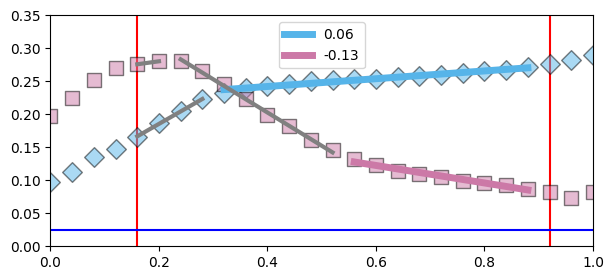

In [215]:
cidx = 1347

fig, ax = plt.subplots(1,1, figsize=(7,3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].axvline(Xs[pss.start], c='r', zorder=1)
ax[j].axvline(Xs[pss.stop], c='r', zorder=1)
ax[j].axhline(0.025, c='b', zorder=1)
xs = Xs[pss]
for gidx in Genes:
    t = transcriptomes[gidx]
    n_seg = df.loc[cidx, t+'_L']
    Ys = peripherality[cidx].loc[gidx].values

    ax[j].scatter(Xs, Ys, color=Cs[gidx], marker=Ms[gidx], edgecolor='k', s=100, zorder=2, alpha=0.5)

    k = df.loc[cidx, ['{}-L{}{}-len'.format(t, n_seg, k) for k in range(n_seg)] ].argmax()
    m, b = df.loc[cidx, [ '{}-L{}{}-{}'.format(t, n_seg, k, c) for c in ['m','b'] ] ].values.astype(float)
    start, stop = df.loc[cidx, [ '{}-L{}{}-{}'.format(t, n_seg, k, c) for c in ['start','stop'] ] ].values.astype(int)
    stop -= 1
    ax[j].plot( [ xs[start], xs[stop] ], [m*xs[start] + b, m*xs[stop]+b], c=Cs[gidx] , zorder=3, lw=5, label='{:.2f}'.format(m))

    for k in np.setdiff1d(range(n_seg), [k]):
        m, b = df.loc[cidx, [ '{}-L{}{}-{}'.format(t, n_seg, k, c) for c in ['m','b'] ] ].values.astype(float)
        ll, start, stop = df.loc[cidx, [ '{}-L{}{}-{}'.format(t, n_seg, k, c) for c in ['len', 'start','stop'] ] ].values.astype(int)
        stop -= 1
        ax[j].plot( [ xs[start], xs[stop] ], [m*xs[start] + b, m*xs[stop]+b], c='gray' , zorder=4, lw=3)


ax[j].legend()
ax[j].set_xlim(0,1)
ax[j].set_ylim(0, max([peripherality[cidx].max(axis=None), 0.3])+0.05);